In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### let's build a Value class to represent a single scalar value, and the operations that can be performed on it

#### Creating Computational Graphs

In [2]:
from graphviz import Digraph

def trace(root):
    # Builds sets of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build_graph(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build_graph(child)
    build_graph(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR here means left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in graph create a rectangular ('record') node for it
        dot.node(name = uid, label = f"{{ {n.label} | data: {n.data:.4f} | grad: {n.grad:.4f} }}", shape='record')
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect it to this value node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connec n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

#### Creating the Vlue Class with automatic differentiation capabilities

In [20]:
# creating a value class that supports automatic differentiation

class Value:

    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # by default, do nothing
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad              # += instead of = for grad accumulation
            other.grad += 1.0 * out.grad             # += instead of = for grad accumulation

        out._backward = _backward 
        return out
    
    def __radd__(self,other):   # for the order (other + self)
        return self+other
    

    def __neg__(self):
        return self * -1

    def __sub__(self,other):
        return self + (-other)

    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad      # += instead of = for grad accumulation
            other.grad += self.data * out.grad      # += instead of = for grad accumulation

        out._backward = _backward 
        return out
    
    def __rmul__(self,other):   # for the order (other * self)
        return self*other
    
    def __pow__(self,other):
        assert isinstance(other, (int, float, Value)), "only supporting int/float/Value powers for now"
        if isinstance(other, Value):
            other = other.data
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad   # += instead of = for grad accumulation

        out._backward = _backward 
        return out

    def __truediv__(self,other):
        return self * other**-1        
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad        # += instead of = for grad accumulation

        out._backward = _backward 
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad        # += instead of = for grad accumulation

        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [35]:
# Using tanh activation function directly

# inputs of the neuron: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron: b
b = Value(6.8813735870195432, label='b') # bias is set to 6.8813735870195432 to get output close to 1.0

# x1*w1 + x2*w2 + b (step by step)
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# applying activation function of tanh
o = n.tanh(); o.label = 'o'
o.backward()

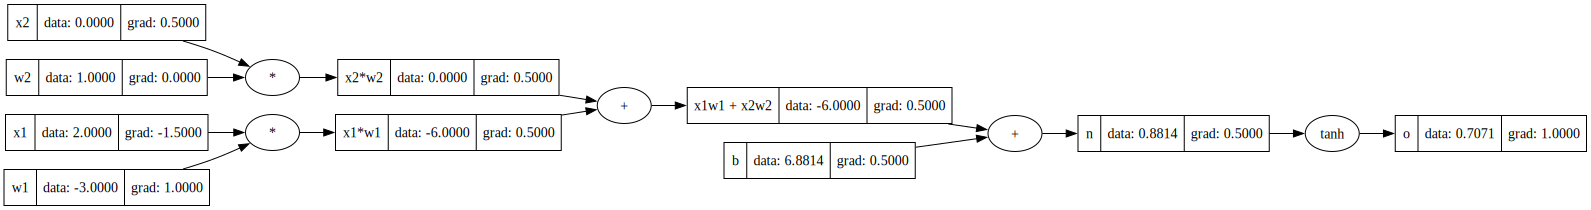

In [36]:
draw_dot(o)

In [33]:
# Applying tanh activation function by its exponential definition

# inputs of the neuron: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron: b
b = Value(6.8813735870195432, label='b') # bias is set to 6.8813735870195432 to get output close to 1.0

# x1*w1 + x2*w2 + b (step by step)
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# applying activation function of tanh (by exponential definition)
e = (2*n).exp()
o = (e - 1)/(e + 1); o.label = 'o'
o.backward()

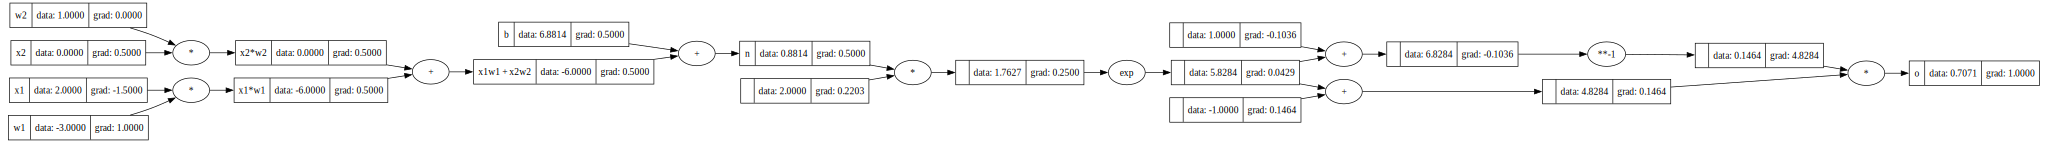

In [34]:
draw_dot(o)